In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random
from einops.layers.torch import Rearrange
from einops import rearrange

from typing import Any, Dict, Tuple, Optional
from game_mechanics import (
    State,
    all_legal_moves,
    choose_move_randomly,
    human_player,
    is_terminal,
    load_pkl,
    play_go,
    reward_function,
    save_pkl,
    transition_function,
)
from game_mechanics.go_env import GoEnv
from tqdm.notebook import tqdm

from functools import partial
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

from network import *
from configs.v0_PPO_MCTS import *
from MCTS import *
from utils import EpisodeReplayMemory
from torch.utils.tensorboard import SummaryWriter

# from utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
env = GoEnv(choose_move_randomly)
state, reward, done, info = env.reset() 
net = AlphaGoZeroBatch(n_residual_blocks=architecture_settings['n_residual_blocks'], 
                       block_width=architecture_settings['block_width'])
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [4]:
def entropy(values, T=1):
    probs = F.softmax(values/T, dim=0)
    nonzero_probs = probs[probs != 0]
    return -(torch.log(nonzero_probs)*nonzero_probs).sum()

def find_optimal_temp(values, desired_bits, temps_to_check = np.logspace(-2, 2, 1000)):
    if len(temps_to_check) == 1: return temps_to_check[0]
    mid_index = round(len(temps_to_check)/2)
    mid_ent1 = entropy(values, T=temps_to_check[mid_index-1])
    mid_ent2 = entropy(values, T=temps_to_check[mid_index])
    if np.isnan(mid_ent1):
        return find_optimal_temp(values, desired_bits, temps_to_check[mid_index:])
    if np.isnan(mid_ent2):
        return find_optimal_temp(values, desired_bits, temps_to_check[:mid_index])
    if mid_ent2 < desired_bits:
        return find_optimal_temp(values, desired_bits, temps_to_check[mid_index:])
    elif mid_ent1 > desired_bits:
        return find_optimal_temp(values, desired_bits, temps_to_check[:mid_index])
    else:
        return temps_to_check[mid_index-1]

def softmax_visit_counts(node, entropy_share=0.5, verbose=False):
    '''
    softmax visit counts, such that the entropy is x% of the max possible entropy
    '''
    visits = torch.as_tensor(node.child_number_visits)
    # remove illegal moves
    mask = torch.as_tensor([move not in node.legal_moves for move in range(82)])
    visits = visits.masked_fill(mask, -torch.inf)
    
    visited_children = (node.child_number_visits > 0).sum()
    max_entropy = np.log(visited_children) # len(node.legal_moves)
    desired_bits = max_entropy*entropy_share
    if visited_children == 1:
        optimal_temperature = 1
    else:
        optimal_temperature = find_optimal_temp(visits, desired_bits)
    if verbose:
        print(f'Max entropy possible: {round(max_entropy, 2)}; we want {round(desired_bits, 2)} bits. Temperature: {optimal_temperature}')
    MCTS_policy = F.softmax(visits/optimal_temperature)
    return MCTS_policy
    
    
# softmax_visit_counts(root, verbose=True)

In [5]:
def choose_move_network(network, state):
    board = rearrange(tensorize(state), 'w h -> 1 w h')
    legal_moves = all_legal_moves(state.board, state.ko)
    with torch.no_grad():
        policy, value = network(board, [legal_moves])
    chosen_move = np.random.choice(range(0,82), p=policy.squeeze().numpy())
    return chosen_move

play_go(your_choose_move = partial(choose_move_network, network=net),
        opponent_choose_move = choose_move_randomly,
        game_speed_multiplier = 100000,
        render=False)

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


1

In [ ]:
batch_size = 16
root = UCTNode(state, move=0, parent=DummyNode())
for _ in range(num_reads):
    leaf = root.select_leaf()
    print(leaf.state)
    print(leaf.legal_moves)
    board = tensorize(leaf.state)
    legal_moves = leaf.legal_moves #all_legal_moves(leaf.state.board, leaf.state.ko)
    with torch.no_grad():
        child_priors, value_estimate = network(rearrange(board, 'w h -> 1 w h'), [legal_moves])
        leaf.expand(child_priors.squeeze())
        leaf.backup(value_estimate.squeeze())
return root

In [129]:
for evals in [100, 200, 500, 1000, 2000]:
    start = datetime.now()
    expanded_root = UCT_search(state, evals, batch_size=16, network=net)
    seconds = (datetime.now() - start).total_seconds()
    print(f'{evals} evaluations took {seconds} seconds: {evals/seconds} per second')

100 evaluations took 0.372708 seconds: 268.30655633901074 per second
200 evaluations took 0.713963 seconds: 280.1265611803413 per second
500 evaluations took 3.098474 seconds: 161.36975814546128 per second
1000 evaluations took 3.339713 seconds: 299.4269268047883 per second
2000 evaluations took 7.260508 seconds: 275.4628188550994 per second


In [70]:
for evals in [100, 200, 500, 1000, 2000]:
    start = datetime.now()
    expanded_root = UCT_search(state, evals, network=net)
    seconds = (datetime.now() - start).total_seconds()
    print(f'{evals} evaluations took {seconds} seconds: {evals/seconds} per second')

100 evaluations took 1.074597 seconds: 93.05814179641298 per second
200 evaluations took 1.966208 seconds: 101.71863810949809 per second
500 evaluations took 5.373205 seconds: 93.05433163261034 per second
1000 evaluations took 11.824173 seconds: 84.57251090625958 per second
2000 evaluations took 23.606968 seconds: 84.72074855186825 per second


In [86]:
def play_opponent_manually(state):
    move = int(input("enter move for opponent"))
    return move

In [7]:
for evals in [100, 200, 500, 1000, 2000]:
    start = datetime.now()
    expanded_root = UCT_search(state, evals, network=net)
    seconds = (datetime.now() - start).total_seconds()
    print(f'{evals} evaluations took {seconds} seconds: {evals/seconds} per second')

100 evaluations took 1.023669 seconds: 97.68782682683563 per second
200 evaluations took 2.044513 seconds: 97.82280670262308 per second
500 evaluations took 7.683586 seconds: 65.07378195545674 per second
1000 evaluations took 12.663248 seconds: 78.96868165260604 per second
2000 evaluations took 35.46358 seconds: 56.395885581771495 per second


In [16]:
## fill erm with some data:
erm = EpisodeReplayMemory(gamma=1, lamda=1)

state, reward, done, info = env.reset() 
while len(erm) < 256:
    train_this_move = False
    if random.random() > 0.0:
        train_this_move = True
        expanded_root = UCT_search(state, 100, network=net)
    else:
        expanded_root = UCT_search(state, 20, network=net)
        
    MCTS_policy = softmax_visit_counts(expanded_root, entropy_share=0.4, verbose=False)
    chosen_move = np.random.choice(range(0,82), p=MCTS_policy.numpy())
    erm.append({'board': tensorize(state),
                'to_play': state.to_play,
                'MCTS_policy': MCTS_policy,
                'reward': reward,
                'done': done,
                'MCTS_value': expanded_root.total_value/expanded_root.number_visits,
                'chosen_move': chosen_move,
                'legal_moves': expanded_root.legal_moves})
    state, reward, done, info = env.step(chosen_move)
    if done:
        state, reward, done, info = env.reset() 
    print(len(erm))

/tmp/ipykernel_2830/463266434.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  MCTS_policy = F.softmax(visits/optimal_temperature)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256


In [72]:
data = erm.sample(256)
start = datetime.now()
policy, value = net(data['board'], data['legal_moves'])
print(datetime.now() - start)

0:00:00.103217


In [80]:
data = erm.sample(256)
batch_sizes = [1,8,32,256]
for batch_size in batch_sizes:
    start = datetime.now()

    for idx in range(0,256,batch_size):
        policy, value = net(data['board'][idx:idx+batch_size], data['legal_moves'][idx:idx+batch_size])
    print(f'Batch size {batch_size}: {(datetime.now() - start).total_seconds()} seconds')

Batch size 1: 1.782565 seconds
Batch size 8: 0.376782 seconds
Batch size 32: 0.185721 seconds
Batch size 256: 0.111401 seconds


In [33]:
%%timeit
data['board'].to('cuda')

43.3 µs ± 22.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%%timeit
transition_function(state, 1)

129 µs ± 1.06 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [31]:
len(data['board'])

256

In [28]:
len(data)

9

In [18]:
start = datetime.now()
policy, value = net(data['board'], data['legal_moves'])
print(datetime.now() - start)

0:00:00.109428


In [24]:
start = datetime.now()
UCT_search(state, 400, network=net)
print(datetime.now() - start)

0:00:07.872819


In [19]:
import cProfile

In [ ]:
expanded_root = UCT_search(state, 100, network=net)

In [71]:
cProfile.run("expanded_root = UCT_search(state, 400, network=net)", "profile_uct_search.prof")

In [361]:
erm = EpisodeReplayMemory(gamma=1, lamda=1)

start = datetime.now()
for episode in tqdm(range(1000)):
    state, reward, done, info = env.reset() 
    while not done:
        train_this_move = False
        if random.random() > 0.75:
            train_this_move = True
            expanded_root = UCT_search(state, 100, network=net)
        else:
            expanded_root = UCT_search(state, 20, network=net)
        
        MCTS_policy = softmax_visit_counts(expanded_root, entropy_share=0.4, verbose=False)
        chosen_move = np.random.choice(range(0,82), p=MCTS_policy.numpy())
        erm.append({'board': tensorize(state),
                    'to_play': state.to_play,
                    'MCTS_policy': MCTS_policy,
                    'reward': reward,
                    'done': done,
                    'MCTS_value': expanded_root.total_value/expanded_root.number_visits,
                    'chosen_move': chosen_move,
                    'legal_moves': expanded_root.legal_moves})
        state, reward, done, info = env.step(chosen_move)
    if len(erm) > 100:
        for batch_number in tqdm(range(100)):
            data = erm.sample(1024)
            policy, value = net(data['board'], data['legal_moves'])
            optimizer.zero_grad()
            loss_policy = F.cross_entropy(policy, data['MCTS_policy'])
            loss_value = F.smooth_l1_loss(value, data['MCTS_value'])
            print(f'loss policy: {loss_policy}, loss value: {loss_value}')
            loss = loss_policy + loss_value
            loss.backward()
            optimizer.step()
            
    print(f"We've collected {len(erm)} datapoints for {datetime.now() - start} seconds: {len(erm)/(datetime.now() - start).seconds} per second")

  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\hristo\AppData\Local\Temp\ipykernel_19540\463266434.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  MCTS_policy = F.softmax(visits/optimal_temperature)


We've collected 13 datapoints for 0:00:10.730065 seconds: 1.3 per second
We've collected 95 datapoints for 0:01:20.141384 seconds: 1.1875 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 177 datapoints for 0:02:36.645454 seconds: 1.1346153846153846 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 228 datapoints for 0:03:40.350525 seconds: 1.0363636363636364 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 310 datapoints for 0:04:59.142961 seconds: 1.0367892976588629 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 376 datapoints for 0:06:10.331647 seconds: 1.0162162162162163 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 394 datapoints for 0:06:38.489353 seconds: 0.9899497487437185 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 441 datapoints for 0:07:43.142594 seconds: 0.9524838012958964 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 503 datapoints for 0:08:55.469641 seconds: 0.9401869158878504 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 585 datapoints for 0:10:28.602310 seconds: 0.9315286624203821 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 637 datapoints for 0:11:42.379082 seconds: 0.9074074074074074 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 718 datapoints for 0:13:12.335810 seconds: 0.9065656565656566 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 800 datapoints for 0:14:41.648735 seconds: 0.9080590238365494 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 837 datapoints for 0:15:40.608768 seconds: 0.8904255319148936 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 914 datapoints for 0:16:38.508502 seconds: 0.9158316633266533 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 996 datapoints for 0:17:27.665016 seconds: 0.9512893982808023 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 1003 datapoints for 0:17:32.297015 seconds: 0.9534220532319392 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 1085 datapoints for 0:18:18.797569 seconds: 0.98816029143898 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 1167 datapoints for 0:19:02.159570 seconds: 1.021891418563923 per second


  0%|          | 0/100 [00:00<?, ?it/s]

We've collected 1247 datapoints for 0:19:47.846323 seconds: 1.050547598989048 per second


C:\Users\hristo\AppData\Local\Temp\ipykernel_19540\1944724173.py:1: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_value = F.smooth_l1_loss(value, data['MCTS_value'], reduction='none')


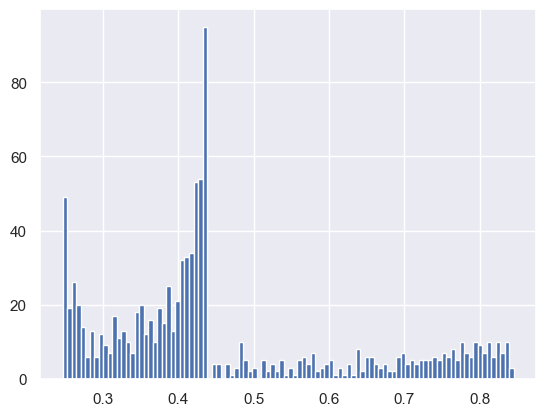

In [382]:
plt.hist(loss_value.mean(axis=1).detach().numpy(), bins=100)
plt.show()

In [381]:
loss_value.sum(axis=1).detach().numpy()

array([507.4759 , 386.26764, 299.96487, ..., 354.0858 , 340.30246,
       340.05304], dtype=float32)

In [379]:
loss_value.sum(axis=1).shape

torch.Size([1024])

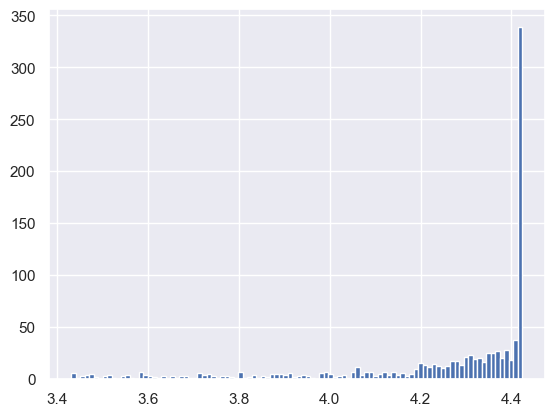

In [373]:
plt.hist(loss_policy.detach().numpy(), bins=100)
plt.show()

In [369]:
F.cross_entropy?

In [367]:
loss_policy

tensor(4.2352, grad_fn=<DivBackward1>)

In [285]:
for _ in range(10):
    if random() > 0.0:
        train_this_move = True
        expanded_root = UCT_search(state, 20, network=net)
    else:
        expanded_root = UCT_search(state, 10, network=net)
    MCTS_policy = softmax_visit_counts(expanded_root)
    if train_this_move:
        loss_policy = F.cross_entropy(MCTS_policy, expanded_root.child_priors)
        loss_value = ???
        loss = loss_policy + loss_value
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

SyntaxError: invalid syntax (2320923032.py, line 10)

In [89]:
MCTS_policy

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.1777, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.1777, 0.0010, 0.0010, 0.1777, 0.0010, 0.1777, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.1777, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0056, 0.0010, 0.0010, 0.0010, 0.0010, 0.0316, 0.0010, 0.0010, 0.0010,
        0.0002])

In [142]:
UCT_search(state, 100)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\hristo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\hristo\AppData\Local\Temp\ipykernel_15496\1143610180.py", line 1, in <cell line: 1>
    UCT_search(state, 100)
  File "C:\Users\hristo\AppData\Local\Temp\ipykernel_15496\3687641478.py", line 9, in UCT_search
    leaf.expand(child_priors)
  File "C:\Users\hristo\Desktop\hristo\Documents\Delta academy\10. Go - version 2\MCTS.py", line 75, in expand
    self.add_child(move, prior)
  File "C:\Users\hristo\Desktop\hristo\Documents\Delta academy\10. Go - version 2\MCTS.py", line 78, in add_child
    self.children[move] = UCTNode(
TypeError: __init__() got an unexpected keyword argument 'prior'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\hristo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py

In [136]:
child_priors, value_estimate

(tensor([[1.5589e-03, 1.1653e-05, 3.7662e-06, 9.2236e-04, 6.7465e-04, 1.3764e-03,
          6.8952e-05, 6.3216e-05, 3.0332e-05, 4.7023e-03, 1.9838e-04, 2.2386e-03,
          6.8988e-05, 1.1084e-04, 1.1322e-05, 1.6468e-02, 4.3807e-05, 4.7380e-04,
          3.8540e-04, 1.4796e-04, 1.2050e-04, 3.2196e-03, 8.8610e-05, 7.1535e-04,
          1.2733e-02, 4.4830e-05, 6.5298e-04, 4.1213e-03, 8.8000e-04, 3.2804e-04,
          0.0000e+00, 1.2305e-03, 4.6648e-06, 7.6269e-04, 5.0985e-04, 2.7422e-05,
          3.4910e-05, 3.0292e-05, 4.3213e-04, 1.1171e-04, 5.3315e-03, 5.8941e-05,
          3.2259e-03, 1.2023e-01, 1.0001e-04, 1.7365e-04, 2.4314e-04, 1.6219e-04,
          3.8389e-03, 1.9128e-04, 5.9754e-01, 1.5177e-03, 1.0624e-03, 3.6476e-03,
          9.4083e-03, 6.5562e-04, 2.0132e-04, 1.6601e-02, 7.0470e-03, 1.5661e-03,
          2.6365e-06, 7.6630e-04, 4.3640e-04, 1.3819e-03, 3.3995e-03, 1.2943e-03,
          7.4992e-02, 9.2330e-04, 2.6621e-03, 7.3676e-05, 6.7479e-04, 4.4354e-05,
          1.6851

In [126]:
legal_moves

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81])

In [ ]:
root = UCTNode(game_state, move=None)
for _ in range(num_reads):
    leaf = root.select_leaf()
    board = tensorize(state)
    legal_moves = all_legal_moves(state)
    child_priors, value_estimate = net(board, legal_moves)

In [12]:
env = GoEnv(choose_move_randomly)

In [101]:
state, reward, done, info = env.reset() 

In [116]:
tensorize(state)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [113]:
tree = UCT_search(state, 100)

NameError: name 'NeuralNet' is not defined

In [66]:
def tensorize(state):
    return torch.as_tensor(state.board, dtype=torch.float32)

for games in range(10):
    boards = []
    legal_moves = []
    state, reward, done, info = env.reset() 
    for while not done:
        state, reward, done, info = env.step(move)
        tree = UCTSearch
        boards.append(tensorize(state))
        legal_moves.append(all_legal_moves(state.board, state.ko))

In [69]:
boards = torch.stack(boards)

In [71]:
boards.shape

torch.Size([5, 9, 9])

In [85]:
net(boards, legal_moves)

(tensor([[0.0000e+00, 1.7069e-02, 4.2378e-03, 2.8627e-03, 1.2309e-03, 1.1055e-03,
          4.2781e-04, 5.9385e-02, 1.3311e-03, 4.3965e-03, 9.1464e-03, 1.4114e-02,
          1.3187e-02, 1.2248e-03, 1.1151e-02, 2.4886e-02, 3.0666e-03, 1.2912e-03,
          4.5420e-03, 2.1956e-03, 4.1933e-03, 5.6979e-03, 1.9598e-03, 3.8316e-03,
          2.1236e-02, 5.1215e-03, 8.1335e-03, 3.6050e-03, 2.0207e-02, 1.3014e-03,
          6.0377e-03, 8.7932e-04, 4.5097e-02, 4.6495e-02, 3.6479e-03, 4.9087e-04,
          8.2803e-03, 3.1976e-03, 1.6818e-02, 3.6947e-03, 9.2572e-03, 9.1271e-04,
          1.5196e-02, 1.7517e-03, 1.3186e-02, 4.6502e-03, 1.0345e-03, 3.2948e-03,
          1.7118e-02, 6.5746e-03, 3.0423e-02, 7.7311e-02, 5.7950e-02, 2.5900e-03,
          2.1337e-02, 0.0000e+00, 2.9044e-03, 1.3965e-01, 8.0718e-03, 8.9049e-03,
          4.4472e-04, 4.5735e-03, 4.4404e-02, 2.9204e-03, 4.3449e-03, 4.3044e-03,
          6.9560e-03, 1.5270e-02, 1.9981e-03, 3.5350e-03, 2.7919e-02, 4.3354e-03,
          1.1827